##### What's uplift modeling
Based on the actions taken by customers with an intervention(ex: offer), there is a fundamental segmentation that separates customers into four following groups. <b>The Persudables</b>, customers who only order because of discounting. <b>The Sure Things</b>, customers who would have ordered whether they were given discounting or not. <b>The Lost Causes</b>, customers who will not order whether given a discount or not.<b> The Do Not Disturbs</b>, customers who are less likely to order because there were given discounts. The Objective of this exercise is to identify The Persuadables, by uplift modeling techniques.

<b>Solutioning framework:</b> The generic framework for incremental value(uplift) modeling is through causal risk difference modeling <b><i>P( Order/Offer=Yes, X ) - P( Order/Offer=No, X )</i></b>. There are various approaches through which we can model incremental value like Single Model Approach (S-Learner), Two Model Approach (T-Learner), X-Learner and Transformed Outcome Approach (TOA). 

The details of above techniques are explored in the following sections with <a href='https://ailab.criteo.com/criteo-uplift-prediction-dataset/'>crieto uplift prediction dataset.</a>


In [1]:
import pandas as pd


from pylift import TransformedOutcome
import numpy as np

from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import math



import matplotlib.pyplot as plt
import subprocess
import sys

from pylift import TransformedOutcome
from pylift.eval import UpliftEval
import random
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.cluster import contingency_matrix
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('/Users/viswanath.g/Downloads/criteo-uplift-v2.1.csv')

In [4]:
df.groupby(['treatment', 'exposure']).agg({'exposure':[ 'count']})

exposure
                       count
treatment exposure          
0         0          2096937
1         0         11454443
          1           428212

In [5]:
features = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']

##### Train & Test Split

In [6]:
df_sample = df.sample(frac =.3) 

train_df = df_sample.sample(frac = 0.5)
test_df  = df_sample.drop(train_df.index)


In [7]:
df_sample.shape, train_df.shape, test_df.shape

((4193878, 16), (2096939, 16), (2096939, 16))

In [8]:
print(train_df.groupby(['treatment', 'exposure']).agg({'exposure':[ 'count']}))
print(test_df.groupby(['treatment', 'exposure']).agg({'exposure':[ 'count']}))

                   exposure
                      count
treatment exposure         
0         0          314264
1         0         1718298
          1           64377
                   exposure
                      count
treatment exposure         
0         0          314452
1         0         1718118
          1           64369


##### Two Model Approach

q2_aqini:  0.089 q2_qini:  0.108 q2_cgains:  0.086


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

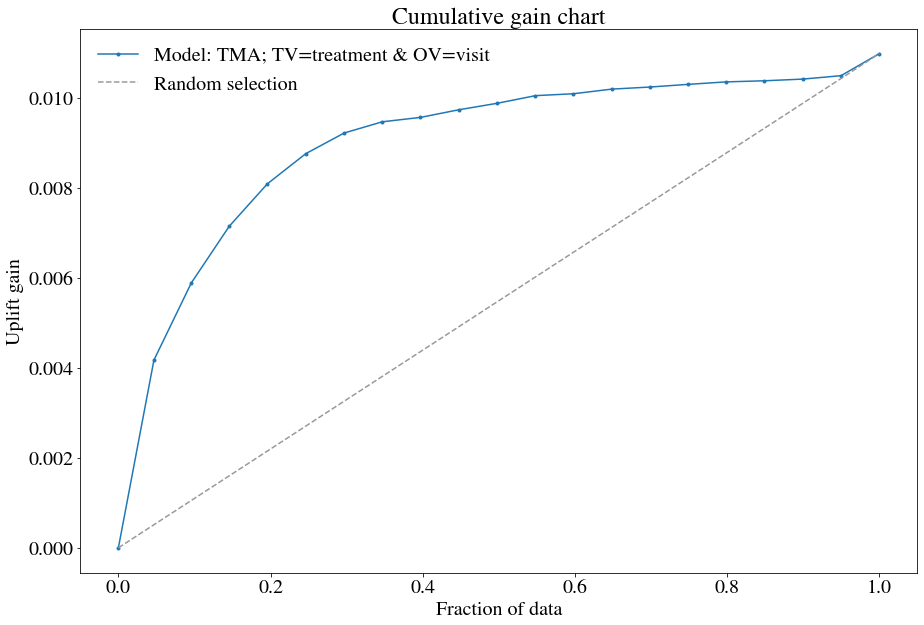

In [9]:
outcomeCol   = 'visit'
treatmentCol = 'treatment'

treated_data    = train_df[train_df[treatmentCol] == True ]
control_data    = train_df[train_df[treatmentCol] == False] 

P_T = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
P_C = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

test_data_val_pred    = P_T.predict_proba( test_df[features] ) 
control_data_val_pred = P_C.predict_proba( test_df[features] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains', label='Model: TMA; TV=treatment & OV=visit')

q2_aqini:  0.137 q2_qini:  0.154 q2_cgains:  0.133


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

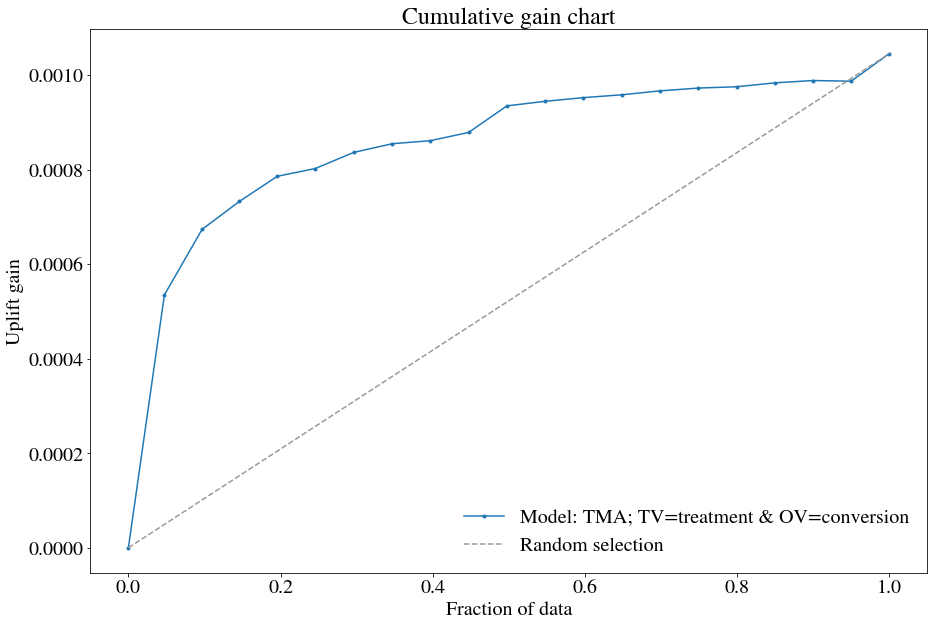

In [10]:
outcomeCol   = 'conversion'
treatmentCol = 'treatment'

treated_data    = train_df[train_df[treatmentCol] == True ]
control_data    = train_df[train_df[treatmentCol] == False] 

P_T = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
P_C = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

test_data_val_pred    = P_T.predict_proba( test_df[features] ) 
control_data_val_pred = P_C.predict_proba( test_df[features] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains', label='Model: TMA; TV=treatment & OV=conversion')

##### One Model Approach

q2_aqini:  0.089 q2_qini:  0.114 q2_cgains:  0.086


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

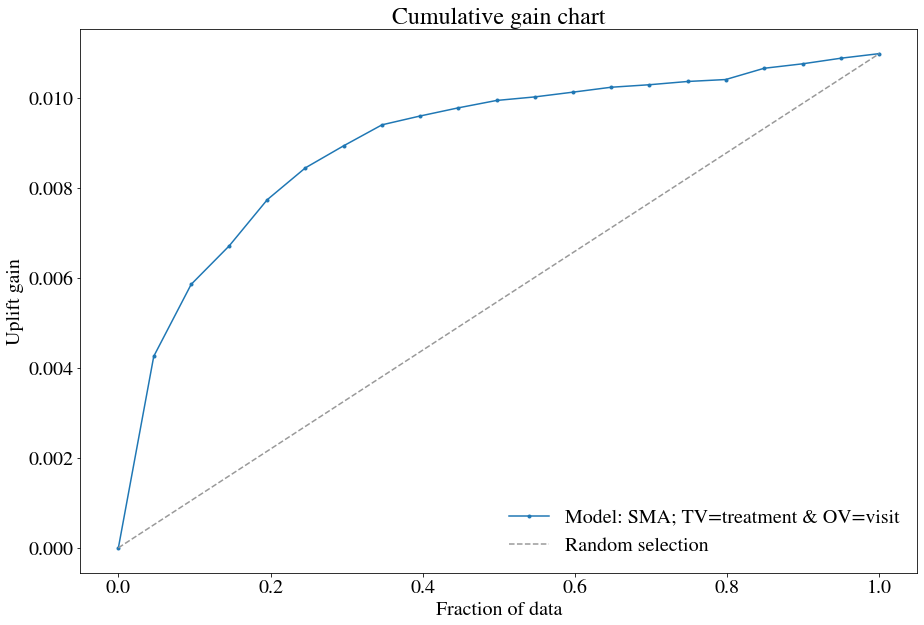

In [11]:
outcomeCol   = 'visit'
treatmentCol = 'treatment'

train_df[f'{treatmentCol}_mod'] = train_df[treatmentCol]
test_df[f'{treatmentCol}_mod']  = test_df[treatmentCol]

propModel = GradientBoostingClassifier().fit(train_df[features + [f'{treatmentCol}_mod']], train_df[outcomeCol] )


test_df[f'{treatmentCol}_mod'] = 1
test_data_val_pred    = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )
test_df[f'{treatmentCol}_mod'] = 0
control_data_val_pred = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains', label='Model: SMA; TV=treatment & OV=visit')


q2_aqini:  0.162 q2_qini:  0.187 q2_cgains:  0.157


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

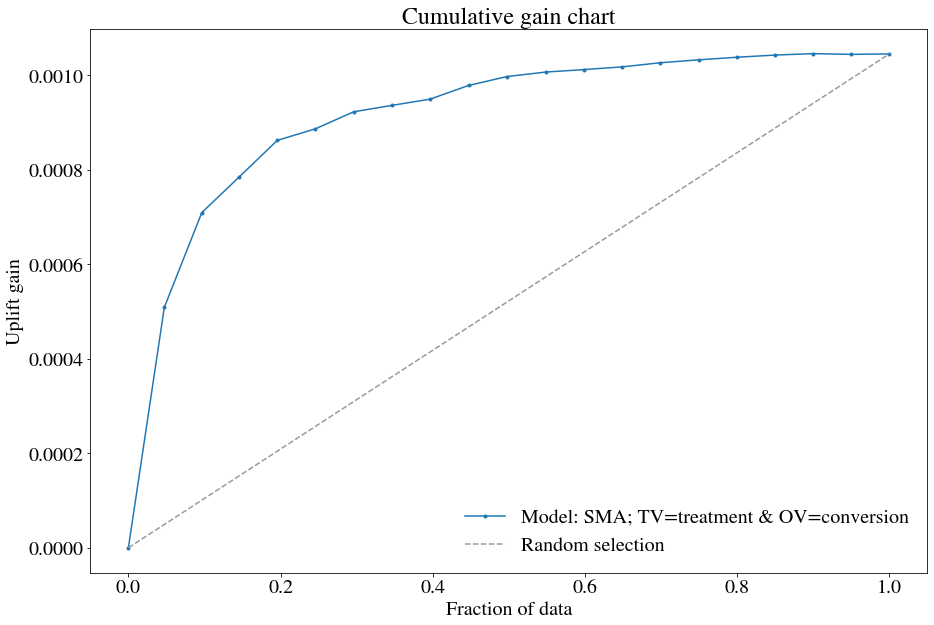

In [12]:
outcomeCol   = 'conversion'
treatmentCol = 'treatment'

train_df[f'{treatmentCol}_mod'] = train_df[treatmentCol]
test_df[f'{treatmentCol}_mod']  = test_df[treatmentCol]

propModel = GradientBoostingClassifier().fit(train_df[features + [f'{treatmentCol}_mod']], train_df[outcomeCol] )


test_df[f'{treatmentCol}_mod'] = 1
test_data_val_pred    = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )
test_df[f'{treatmentCol}_mod'] = 0
control_data_val_pred = propModel.predict_proba( test_df[features + [f'{treatmentCol}_mod']] )

test_df['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains', label='Model: SMA; TV=treatment & OV=conversion')


##### CATE-Generating outcome transformer

Propensity Score Model is Built
q2_aqini:  0.09 q2_qini:  0.113 q2_cgains:  0.088


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

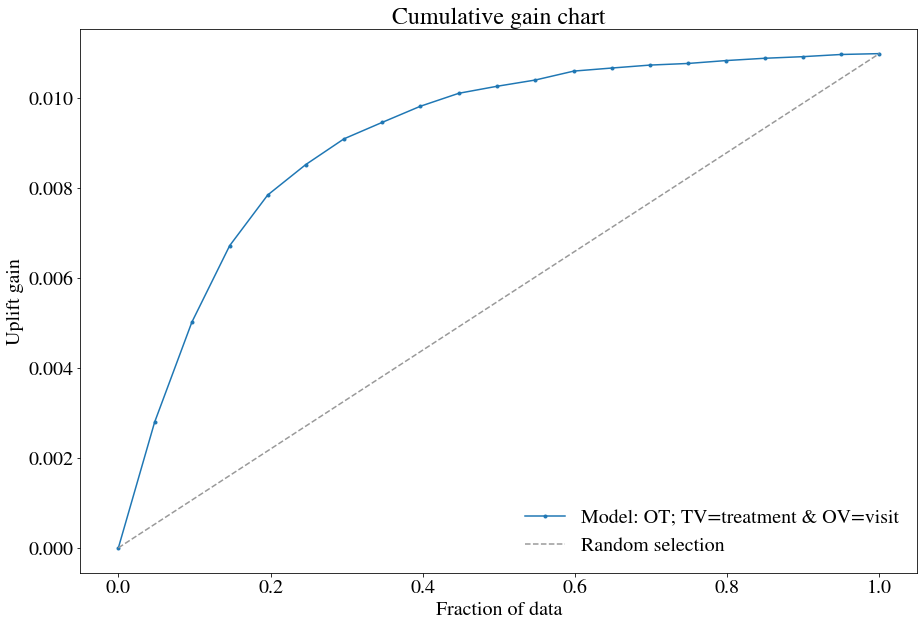

In [13]:
outcomeCol   = 'visit'
treatmentCol = 'treatment'


psModel = GradientBoostingClassifier().fit( train_df[features], train_df[treatmentCol]  )

propensityScore = psModel.predict_proba( train_df[features] )
train_df['ps'] = np.where(train_df[treatmentCol] == 1, propensityScore[:,1], propensityScore[:,0])

print('Propensity Score Model is Built')

train_df['y_mod']  = ( 
                        train_df[outcomeCol] * ( train_df[treatmentCol] - train_df['ps']) 
                                   / 
                       ( train_df['ps'] * ( 1-train_df['ps'] ) )
                      )


cateModel = GradientBoostingRegressor().fit(train_df[features], train_df['y_mod'] )

test_df['uplift'] = cateModel.predict( test_df[features] )


upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains', label='Model: OT; TV=treatment & OV=visit')

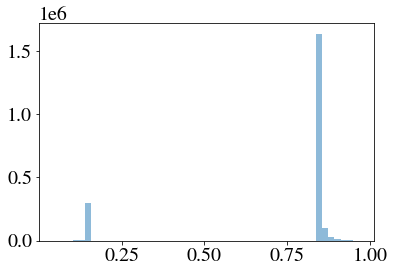

In [15]:
# propensity score distribution
_ = plt.hist(train_df['ps'], bins=50, alpha=0.5)
# below distributions clearly tells us that the data generates by Incrementality tests

Propensity Score Model is Built
q2_aqini:  0.159 q2_qini:  0.184 q2_cgains:  0.154


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

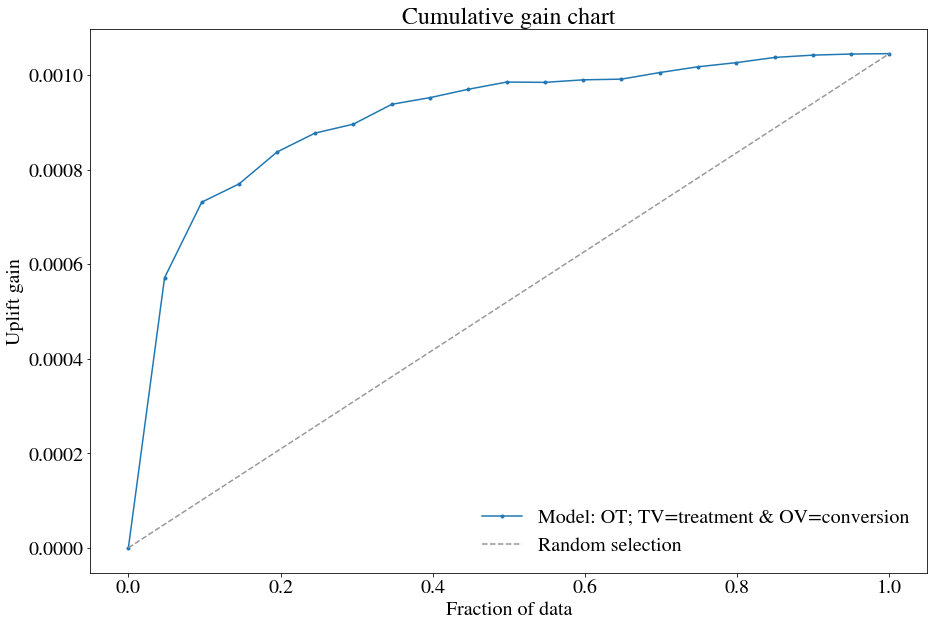

In [16]:
outcomeCol   = 'conversion'
treatmentCol = 'treatment'

psModel = GradientBoostingClassifier().fit( train_df[features], train_df[treatmentCol]  )

propensityScore = psModel.predict_proba( train_df[features] )
train_df['ps'] = np.where(train_df[treatmentCol] == 1, propensityScore[:,1], propensityScore[:,0])

print('Propensity Score Model is Built')

train_df['y_mod']  = ( 
                        train_df[outcomeCol] * ( train_df[treatmentCol] - train_df['ps']) 
                                   / 
                       ( train_df['ps'] * ( 1-train_df['ps'] ) )
                      )


cateModel = GradientBoostingRegressor().fit(train_df[features], train_df['y_mod'] )

test_df['uplift'] = cateModel.predict( test_df[features] )


upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains', label='Model: OT; TV=treatment & OV=conversion')

##### X-Learner

More details can on X-Learner can be found <a href='https://doordash.engineering/2020/09/18/causal-modeling-to-get-more-value-from-flat-experiment-results/comment-page-1/?unapproved=16&moderation-hash=7fa9a26e6386c27d25dbca6d1c777441#comments'>here</a>

In [ ]:

outcomeCol   = 'visit'
treatmentCol = 'treatment'


psModel = GradientBoostingClassifier().fit( train_df[features], train_df[treatmentCol]  )

treated_data    = train_df[train_df.treatment == True ]
control_data    = train_df[train_df.treatment == False] 

T_X = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
C_X = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

treated_data['DT_Y'] = treated_data[outcomeCol] - C_X.predict_proba(treated_data[features])[:,1]
control_data['DC_Y'] = T_X.predict_proba(control_data[features])[:,1] - control_data[outcomeCol]

DT_X = GradientBoostingRegressor().fit(treated_data[features], treated_data['DT_Y'])
DC_X = GradientBoostingRegressor().fit(control_data[features], control_data['DC_Y'])

test_df['uplift'] = ( 
    psModel.predict_proba(test_df[features])[:,1] * DC_X.predict(test_df[features])
                         +
    psModel.predict_proba(test_df[features])[:,0] * DT_X.predict(test_df[features])
)

upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains', label='Model: X-Learner; TV=treatment & OV=visit')

                
                     

In [ ]:
outcomeCol   = 'conversion'
treatmentCol = 'treatment'
df_sample = df.sample(frac =.3) 
# df_sample.drop(['conversion', 'exposure'], inplace=True, axis=1)

psModel = GradientBoostingClassifier().fit( train_df[features], train_df[treatmentCol]  )

treated_data    = train_df[train_df.treatment == True ]
control_data    = train_df[train_df.treatment == False] 

T_X = GradientBoostingClassifier().fit(treated_data[features], treated_data[outcomeCol] )
C_X = GradientBoostingClassifier().fit(control_data[features], control_data[outcomeCol] )

treated_data['DT_Y'] = treated_data[outcomeCol] - C_X.predict_proba(treated_data[features])[:,1]
control_data['DC_Y'] = T_X.predict_proba(control_data[features])[:,1] - control_data[outcomeCol]

DT_X = GradientBoostingRegressor().fit(treated_data[features], treated_data['DT_Y'])
DC_X = GradientBoostingRegressor().fit(control_data[features], control_data['DC_Y'])

test_df['uplift'] = ( 
    psModel.predict_proba(test_df[features])[:,1] * DC_X.predict(test_df[features])
                         +
    psModel.predict_proba(test_df[features])[:,0] * DT_X.predict(test_df[features])
)

upev = UpliftEval(test_df[treatmentCol], test_df[outcomeCol], test_df.uplift)

print('q2_aqini: ', round(upev.q2_aqini,3), 'q2_qini: ', round(upev.q2_qini,3), 'q2_cgains: ', round(upev.q2_cgains,3))

upev.plot(plot_type='cgains', label='Model: X-Learner; TV=treatment & OV=conversion')

                
                     

###### Resources

- <a href='https://doordash.engineering/2020/09/18/causal-modeling-to-get-more-value-from-flat-experiment-results/comment-page-1/?unapproved=16&moderation-hash=7fa9a26e6386c27d25dbca6d1c777441#comments'>Leveraging Causal Modeling to Get More Value from Flat Experiment Results</a>
- <a href='https://pypi.org/project/pylift/'>pylift package</a>
- <a href=''>scikit-uplift</a>